In [212]:
import torch
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt


In [213]:
# load names data set into a list of words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [214]:
len(words)

32033

In [215]:
# assign each unique character in the data set a unique number mapping 
# remove duplicate letters
c_set = set(''.join(words))
chars = sorted(list(c_set))

# create a dictionary that assigns each letter in the chars list an integer
# stoi is shifted one, a = 1, so that '.' = 0
stoi = {s:i+1 for i, s in enumerate(chars)} # char to int dict
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # int to char dict
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [216]:
# build the data set (three input characters x1, x2, x3 and the next character output y1)
block_size = 3 # this is the number of characters inputed for a single output (context length)
X, Y = [], []
for w in words:

    # context is a rolling window over the word of size 3, always behind the current char in loop below
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '----->', itos[ix])
        
        # shift context window
        context = context[1:] + [ix] 

# turn list into workable tensors
X = torch.tensor(X)
Y = torch.tensor(Y)


In [217]:
X.shape, Y.shape 

(torch.Size([228146, 3]), torch.Size([228146]))

In [256]:
def build_dataset(words, bk_sz):
    block_size = bk_sz  # context length
    X, Y = [], []

    for w in words:

        # context is a rolling window over the word of size 3, always behind the current char in loop below
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '----->', itos[ix])
            
            # shift context window
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_tr, Y_tr = build_dataset(words[:n1], 3)
X_dev, Y_dev = build_dataset(words[n1:n2], 3)
X_te, Y_te = build_dataset(words[n2:], 3)


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [219]:
# create embedding maxtrix C, look up table
# takes 27 possible characters into a 2 dim space vector space
C = torch.randn((27,2))
emb = C[X] # embeds all inputs in X at once
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
# ---------------putting a full network together------------

In [243]:
# training split 80%, dev/val 10%, test split 10%
X_tr.shape, Y_tr.shape 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g) 
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) 
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [244]:
sum(p.nelement() for p in parameters) # number of parameters in the network

11897

In [245]:
for p in parameters:
    p.requires_grad = True

In [246]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponents
lrs = 10**lre # 1000 learning rates from 10**-3 to 1 expontentially distributed

In [247]:
lri = []
loss_lri = []
step_i = []

In [248]:
# training loop
for i in range(200000):

    # mini batch construction ( batch size of 32 )
    ix = torch.randint(0, X_tr.shape[0], (32,))
    
    # forward pass and the loss expressing the accuracy with the loss
    emb = C[X_tr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    # lr = lrs[i]
    lr = 0.5 if i < 100000 else i 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    step_i.append(i)
    loss_lri.append(loss.log10().item())
    

print(loss.item())

2.0477519035339355


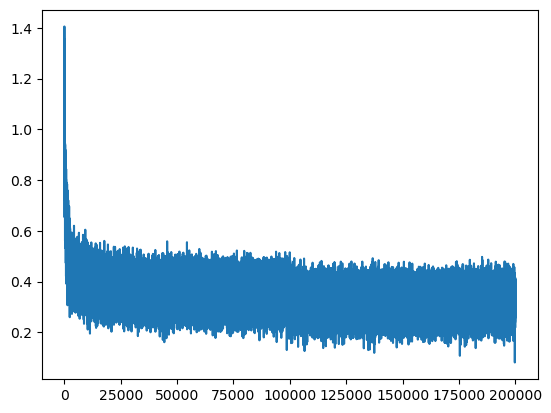

In [249]:
plt.close()
plt.plot(step_i, loss_lri)
plt.show()

In [250]:
emb = C[X_dev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss.item()

2.155813455581665

In [251]:
emb = C[X_tr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
loss.item()

2.118306875228882

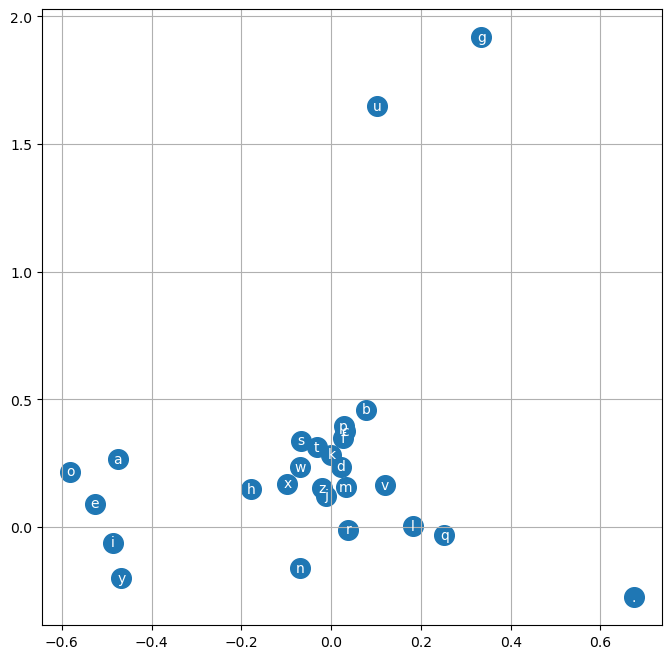

In [203]:
# visualize the vector embeddings 
plt.close('all')
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')
plt.show()

In [ ]:
#----------- Imporvements ---------------
# cleaned up build_dataset function to allow for varrying  block_size.
# added a fully connected funtion to make the first layer modular wrt varrying input sizes.
# added a dynamic decaying learning rate.

In [267]:
# build the data set
import random
block_size = 3

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_tr, Y_tr = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_te, Y_te = build_dataset(words[n2:], block_size)

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [268]:
# training split 80%, dev/val 10%, test split 10%
X_tr.shape, Y_tr.shape 
word_emb_size = 10

# randomly generate starting parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,word_emb_size), generator=g)
W1 = torch.randn((word_emb_size * block_size, 200), generator=g) 
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) 
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [269]:
# number of parameters in the network
sum(p.nelement() for p in parameters) 

11897

In [270]:
for p in parameters:
    p.requires_grad = True

In [271]:
def full_cont(emb_m, w, b):
    emb_dim = word_emb_size * block_size
    h = torch.tanh(emb_m.view(-1, emb_dim) @ w + b)
    return h

In [279]:
# training loop
epochs = 200000
batch_size = 64

for i in range(epochs):

    # mini batch construction
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    
    # forward pass and the loss expressing the accuracy with the loss
    emb = C[X_tr[ix]] 
    h = full_cont(emb, W1, b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters and learning rate
    if  i < (epochs/2):
        lr = 0.5
    elif (epochs/2) <= i < (3*epochs/4):
        lr = 0.1 
    else:
        lr = 0.01
        
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    step_i.append(i)
    loss_lri.append(loss.log10().item())
    

print(loss.item())

2.067373752593994


In [280]:
emb = C[X_dev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss.item()

2.1016273498535156

In [281]:
emb = C[X_tr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
loss.item()

2.0153963565826416